Gender Classification project

In [ ]:
import keras
# import nltk
#nltk.download()
# import pandas as pd
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import csv
import re
import string
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import pprint
import tweepy
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
import keras.preprocessing.text as kpt

import numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
import tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics


In [6]:
path = '../input/gender-classifier-DFE-791531.csv'
punctuation = list(string.punctuation)
stop = stopwords.words('english') + list(string.punctuation) + ['rt', 'via', '__']
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
regex_str = [
    emoticons_str,
    r'<[^>]+>',  # HTML tags
    r'(?:@[\w_]+)',  # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)",  # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+',  # URLs
    # r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    # r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)',  # other words
    r'(?:\S)'  # anything else
]
tokens_re = re.compile(r'(' + '|'.join(regex_str) + ')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^' + emoticons_str + '$', re.VERBOSE | re.IGNORECASE)

def tokenize(s):
    s = re.sub(r'[^\x00-\x7f]*',r'',str(s))
    return tokens_re.findall(s)

def cleanAndNormalizeText(data):
    tokens = tokenize(data)
    tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    # remove stop words
    filterText = [w for w in tokens if w not in stop]
    filterText = [w for w in filterText if not len(w) <= 1]
    # stem
    ps = PorterStemmer()
    for i in range(len(filterText) - 1):
        if len(filterText[i]) > 1:
            try:
                filterText[i] = ps.stem(filterText[i])
            except Exception as e:
                filterText[i] = filterText[i]

    return filterText

Get learning data from gender-classifier-DFE-791531.csv file.

for every tweet clean the text and the description and save.

In [8]:
locations = []
terms_male = []
terms_female = []
terms_brand = []
genderClassData = []
with open(path,'r', encoding="utf8" ,errors="ignore") as csvfile:
    reader = csv.reader(csvfile)
    count = 0
    for row in reader:
        if count != 0:
            text = row[10]+' '+row[19]
            locations.append(row[25])
            cleantext = cleanAndNormalizeText(text)
            genderClassData.append([row[0], row[5], ' '.join(cleantext)])
            for token in cleantext:
                if token not in stop:
                    if row[5] == 'male':
                        terms_male.append(token)
                    else:
                        if row[5] == 'female':
                            terms_female.append(token)
                        else:
                            if row[5] == 'brand':
                                terms_brand.append(token)
        count = count+1


Table = pd.DataFrame(genderClassData, columns=['ID', 'gender', 'text'])
Table = Table.loc[Table['gender'].isin(['female', 'male', 'brand'])]
Table.loc[Table['text'].isnull(), 'text'] = "."


Display Class Distribution

   Gender  # of Samples
0    male          6194
1  female          6700
2   brand          5942


Text(0,0.5,'gender')

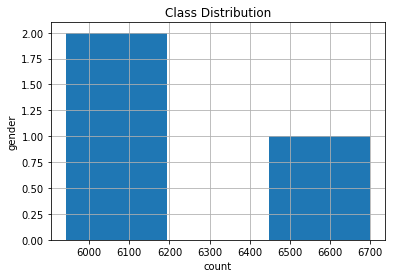

In [9]:
# class distribution
classDistribution = []
for c in ['male', 'female', 'brand']:
    classDistribution.append([c, Table["gender"].value_counts()[c]])
classDis = pd.DataFrame(classDistribution, columns=['Gender', '# of Samples'])
print(classDis)
counter = Counter(Table['gender'])
targetNames = counter.keys()
tweetCounts = counter.values()
indexes = np.arange(len(targetNames))
width = 0.7
plt.bar(indexes, tweetCounts, width)
plt.xticks(indexes + width * 0.5, targetNames)
print('Class distributions summary:')
plt.show()

Display the popular location and term frequency for the diffrent genders.

In [10]:
count_country = Counter()
count_country.update(locations)
print("must popular country:")
print(count_country.most_common(2))

count_male = Counter()
count_male.update(terms_male)
pp = pprint.PrettyPrinter()
print("Male most common:")
pp.pprint(count_male.most_common(50))


count_female = Counter()
count_female.update(terms_female)
print("Female most common:")
pp.pprint(count_female.most_common(50))

count_brand = Counter()
count_brand.update(terms_brand)
print("Brand most common:")
pp.pprint(count_brand.most_common(50))

Male most common: 106680
[('love', 668),
 ('like', 575),
 ('get', 558),
 ('one', 423),
 ('go', 409),
 ('time', 400),
 ('make', 398),
 ('life', 367),
 ('fan', 335),
 ('follow', 331),
 ('day', 313),
 ('know', 290),
 ('new', 286),
 ('good', 276),
 ('music', 275),
 ('peopl', 273),
 ('live', 271),
 ('game', 265),
 ('see', 257),
 ('work', 254),
 ('want', 251),
 ('year', 250),
 ('thing', 249),
 ('look', 246),
 ('man', 241),
 ('think', 235),
 ('best', 228),
 ('tweet', 225),
 ('world', 223),
 ('got', 218),
 ('come', 218),
 ('back', 215),
 ('need', 215),
 ('play', 211),
 ('sport', 209),
 ('fuck', 208),
 ('say', 204),
 ('writer', 187),
 ('im', 185),
 ('would', 181),
 ('still', 180),
 ('also', 175),
 ('way', 172),
 ('alway', 171),
 ('last', 170),
 ('god', 168),
 ('thank', 168),
 ('take', 166),
 ('book', 165),
 ('never', 165)]
Female most common: 102188
[('love', 973),
 ('like', 711),
 ('get', 555),
 ('one', 508),
 ('make', 503),
 ('go', 488),
 ('life', 457),
 ('day', 455),
 ('time', 434),
 ('follo

Split the Data to Train and Test

In [18]:
Table = Table.loc[Table['gender'].isin(['female','male'])]
x = Table['text']
y = Table["gender"]


xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.20, shuffle=True)
token = Tokenizer(num_words=5000)
token.fit_on_texts(x)
dic = token.word_index



              ID                                               text
0      815719226  sing rhythm 08c2c2 ffffff robbi respond critic...
1      815719227  author novel fill famili drama romanc 0084b4 c...
2      815719228  loui whine squeal abb8c2 c0deed absolut ador l...
3      815719229  mobil guy 49er shazam googl kleiner perkin yah...
4      815719230  ricki wilson best frontman kaiser chief best b...
5      815719231  know f5abb5 ive seen peopl train lamp chair tv...
6      815719232  global marketplac imag video music share photo...
7      815719233  secret get ahead get start 0000ff c0deed gala ...
8      815719234  pll fan crazi mcd ramen bae 9266cc @_aphmau_ p...
9      815719235  renaiss art historian univers nottingham fuell...
10     815719236  clean food tast great provid energi nutrient g...
11     815719237  highli extraordinari auction 0084b4 c0deed mtg...
12     815719238  senior 16 xi xii mmxiv 0084b4 ffffff put ass l...
13     815719239  come join fastest blog network

Prepare and Train the keras deep learning model

In [ ]:
# prepare to deep learning model
Train = []
Test = []
for data in xTrain:
    Train.append([dic[word] for word in kpt.text_to_word_sequence(data)])
for data in xTest:
    Test.append([dic[word] for word in kpt.text_to_word_sequence(data)])
Train = np.asarray(Train)
Test = np.asarray(Test)
xTrainMatx = token.sequences_to_matrix(Train, mode='binary')
xTestMatx = token.sequences_to_matrix(Test, mode='binary')
lb_make = LabelEncoder()
trainNum = lb_make.fit_transform(yTrain)
testNum = lb_make.fit_transform(yTest)
yTrainMatx = keras.utils.to_categorical(trainNum,2)
yTestMatx = keras.utils.to_categorical(testNum,2)


model = Sequential()
model.add(Dense(512, input_shape=(5000,), activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(256, input_shape=(5000,), activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(2, input_shape=(5000,), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(xTrainMatx, yTrainMatx,batch_size=128,epochs=5,validation_data=(xTestMatx, yTestMatx), verbose=1, shuffle=True)
scores = model.evaluate(xTestMatx, yTestMatx, verbose=0)

Train Naive bayes and SVM models with Bag of words and TF-IDF.

Show accuracy of all the models

In [19]:
results = []
results.append(['keras deep learning', scores[1]])
def classify(parameters, feature, ml):
            gs_clf = Pipeline(steps=[('vect', feature), ('clf', ml)])
#             gs_clf = GridSearchCV(pipeline, parameters, n_jobs=1)
            gs_clf = gs_clf.fit(xTrain, yTrain)
            prediction = gs_clf.predict(xTest)
            accuracy = metrics.accuracy_score(yTest, prediction)
            return accuracy

parameters = {'vect__max_df': (0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0), 'clf__alpha': (0.001, 0.01, 0.1, 1.0)} # understand why this numbers

# Using classify with Bag of Words and SVM algorithm
ans = classify(parameters, CountVectorizer(), SGDClassifier())
results.append(['SVM with Bag of Words', ans])

# Using classify with Bag of Words and NB algorithm
ans = classify(parameters, CountVectorizer(), MultinomialNB())
results.append(['Naïve Bayes with Bag of Words',  ans])

# Using classify with tf-idf and SVM algorithm
ans = classify(parameters, TfidfVectorizer(sublinear_tf=True, stop_words='english'), SGDClassifier())
results.append(['SVM with TF-IDF', ans])

# Using classify with tf-idf and NB algorithm
ans = classify(parameters, TfidfVectorizer(sublinear_tf=True, stop_words='english'), MultinomialNB())
results.append(['Naïve Bayes with TF-IDF', ans])

accuracy = pd.DataFrame(results, columns=['machine learning algorithm','accuracy'])
print(accuracy)

twitter configuration

In [ ]:
auth = tweepy.OAuthHandler("YzWFDST42FGUpQrqnFd6cT85u", "Ois5i7dau00xpluXjFPuU3Uu20UjDxd9KXbQjd7duXEO370iu8")
auth.set_access_token("1089235299862040576-gxsMbZg9nQgbooxCpsJ33ETDKb6IM5", "bSg2xKANcbIYhxEpL8OMwZIY7gXXbkc2wUkStxMSbU4K7")
api = tweepy.API(auth,  wait_on_rate_limit=True)

Get tweets by stremming api, with the most popular location of the train data.

geo location is: -162.8,28.2,-64.4,71.6 (US & CANADA)


In [ ]:
class MyStreamListener(tweepy.StreamListener):
    num_tweets = 0
    def on_data(self, data):
        if self.num_tweets < 15000:
                try:
                    with open('tweetsFromTwitter.json', 'a') as f:
                        f.write(data)
                        self.num_tweets += 1
                        return True
                except BaseException as e:
                    print("Error on_data: %s" % str(e))
                    return True
        else:
            return False

    def on_error(self, status):
        print(status)
        return True

    def _init_(self, api=None):
        super(MyStreamListener, self)._init_()
        self.num_tweets = 0

myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth=api.auth, listener=myStreamListener)
myStream.filter(locations=[-162.8,28.2,-64.4,71.6])

Read all the tweets from 'tweetsFromTwitter.json' file.

clean every tweet and save it.

In [ ]:
tweetsTwitter = []
for row in open('tweetsFromAPI.json','r'):
    try:
        tweet = json.loads(row)
        cleanTweet = cleanAndNormalizeText(tweet['text'])
        tweetsTwitter.append(cleanTweet)
    except:
        continue

Show must popular words in the testing tweets from twitter

In [ ]:
# most popular terms
terms = []
count = Counter()
for tweet in tweetsTwitter:
    for token in tweet:
        terms.append(token)
count.update(terms)
print(count.most_common(50))

We can see that there is a ovelap between the popular words in the train data and the tweets that we collected from twitter,

we can asume that the overlap is indicate of common words in the lanuaze

Q4 - Predict gender of authors with the best model from Q2.

we can see that the Naive bayes with the TF-IDF bring the best accuracy ~(0.67).

Predict gender for all tweets that we collected

In [ ]:
predictions = []
for tweet in tweetsTwitter:
    if len(tweet) > 0:
        gs_clf = Pipeline([('vect', TfidfVectorizer(sublinear_tf=True, stop_words='english'), ), ('clf', MultinomialNB())])
        # gs_clf = GridSearchCV(pipeline, parameters, n_jobs=1)
        gs_clf = gs_clf.fit(xTrain, yTrain)
        prediction = gs_clf.predict(tweet)
        predct = (word for word in prediction)
        c = Counter(predct)
        predict = c.most_common(1)[0]
        predictions.append([tweet, predict])

Pred = pd.DataFrame(predictions,columns=['Tweet','Gender'])
print(Pred)

we can see the prediction for all the tweets.
    
in every tweet we take the majority classification for all the terms in the tweet.

Show all terms prediction.

In [ ]:
gs_clf = Pipeline([('vect', TfidfVectorizer(sublinear_tf=True, stop_words='english'), ), ('clf', MultinomialNB())])
gs_clf = gs_clf.fit(xTrain, yTrain)
prediction = gs_clf.predict(terms)
maleC = np.count_nonzero(prediction == 'male')
femaleC = np.count_nonzero(prediction == 'female')
plt.pie([maleC, femaleC], explode=(0.1,0), labels=('Male','Female'),colors=['blue','red'],
        autopct='%1.1f%%',shadow=True, startangle=180)
plt.axis('equal')
plt.show()

We can see which gender have the most common words in there tweets.